# Vietnam Coastlines raster generation


* Load stack of all available Landsat 5, 7, 8 and 9 satellite imagery for a location using [ODC Virtual Products](https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Virtual_products.html)
* Convert each satellite image into a remote sensing water index (MNDWI)
* For each satellite image, model ocean tides into a grid based on exact time of image acquisition
* Interpolate tide heights into spatial extent of image stack using the [FES2014 global tide model](https://github.com/GeoscienceAustralia/dea-coastlines/wiki/Setting-up-tidal-models-for-DEA-Coastlines)
* Mask out high and low tide pixels by removing all observations acquired outside of 50 percent of the observed tidal range centered over mean sea level
* Combine tidally-masked data into annual median composites representing the most representative position of the coastline at approximately mean sea level each year

This is an interactive version of the code intended for prototyping; to run this analysis at scale, use the [command line tools](DEACoastlines_generation_CLI.ipynb).

---

## Getting started
Set working directory to top level of repository to ensure links work correctly:

In [1]:
cd ..

/Users/alex/git/auspatious/dea-coastlines


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [2]:
# pip install -r requirements.in --quiet

In [3]:
%matplotlib inline
# %load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import geopandas as gpd
from datacube.utils.geometry import Geometry

from collections import Counter

# Load DEA Coastlines and DEA tools code
import coastlines.raster
import coastlines.utils
from datacube.utils.dask import start_local_dask
from dea_tools.coastal import pixel_tides

from odc.algo import mask_cleanup
from odc.stac import configure_s3_access

# dc = datacube.Datacube(app="DEACoastlines")

# Create local dask client for parallelisation
dask_client = start_local_dask(n_workers=4, threads_per_worker=1, memory_limit="12GB")

# Configure S3 access including request payer
# os.environ["AWS_REQUEST_PAYER"]='requester'
_ = configure_s3_access(profile="alex-read-s3", requester_pays=True, cloud_defaults=True)

## Setup


### Set analysis parameters

In [4]:
study_area = "13,45"
study_area = "9,19"
raster_version = 'testing'
start_year = 2016
end_year = 2022
config_path = 'configs/vietnam_coastlines_config_development.yaml'

# Load analysis params from config file
config = coastlines.utils.load_config(
    config_path=config_path)

### Load supplementary data

<Axes: >

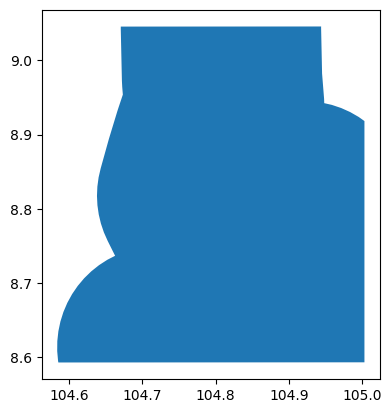

In [5]:
# Albers grid cells used to process the analysis
gridcell_gdf = (
    gpd.read_file(config['Input files']['grid_path']).to_crs(
        epsg=4326).set_index('id'))
gridcell_gdf.index = gridcell_gdf.index.astype(str)
gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]
gridcell_gdf.plot()

## Loading data
### Create spatiotemporal query
This establishes the spatial and temporal extent used to search for Landsat satellite data.


### Load satellite data as MNDWI
This step loads satellite data from Landsat 5, 7, 8 and 9, and returns the data as a cloud-masked array converted to the Modified Normalised Difference Water Index (MNDWI).
For Digital Earth Australia Coastlines, this is achieved using [ODC Virtual Products](https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Virtual_products.html).

In [6]:
# Load MNDWI from STAC
from odc.stac import load
from pystac_client import Client

os.environ['AWS_REQUEST_PAYER'] = 'requester'
usgs_url = "https://landsatlook.usgs.gov/stac-server"
client = Client.open(usgs_url)
collections = ["landsat-c2l2-sr"]

def http_to_s3_url(http_url):
    """Convert a USGS HTTP URL to an S3 URL"""
    s3_url = http_url.replace('https://landsatlook.usgs.gov/data', 's3://usgs-landsat').rstrip(":1")
    return s3_url


In [7]:
# Create query based on analysis gridcell extent
geopoly = Geometry(gridcell_gdf.iloc[0].geometry, crs=gridcell_gdf.crs)
bbox = geopoly.buffer(0.05).boundingbox
query = {
    "bbox": [bbox.left, bbox.bottom, bbox.right, bbox.top],
    "datetime": (str(start_year - 1), str(end_year + 1)),
}

items = list(client.search(collections=collections, **query).get_all_items())

print(f"Found {len(items)} items")

Found 609 items


In [8]:
epsg_codes = Counter(item.properties["proj:epsg"] for item in items)
most_common_epsg = epsg_codes.most_common(1)[0][0]

In [9]:
cfg = {
    "landsat-c2l2-sr": {
        "assets": {
            "*": {"data_type": "uint16", "nodata": 0},
        }
    },
    "*": {"warnings": "ignore"},
}

ds = load(
    items,
    bands=["green", "swir22", "qa_pixel"],
    **query,
    crs=most_common_epsg,
    resolution=30,
    stac_cfg=cfg,
    chunks={"x": 2000, "y": 2000, "time": 1},
    group_by="solar_day",
    patch_url=http_to_s3_url
)

# Mask where there is no data
ds = ds.where(ds.green != 0)

ds["green"] = ds.green.astype("float32") * 0.0000275 + -0.2
ds["swir22"] = ds.swir22.astype("float32") * 0.0000275 + -0.2

ds["mndwi"] = (ds.green - ds.swir22) / (ds.green + ds.swir22)

# Get cloud and cloud shadow mask
# Example here https://stackstac.readthedocs.io/en/v0.3.0/examples/gif.html
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

# Get cloud mask
cloud_mask = ds["qa_pixel"].astype(int) & bitmask != 0

# Expand and contract the mask to clean it up
dilated = mask_cleanup(cloud_mask, [("opening", 2), ("dilation", 3)])

ds = ds.where(~dilated)

ds

<xarray.Dataset>
Dimensions:      (time: 609, y: 2038, x: 1903)
Coordinates:
  * y            (y) float64 1.005e+06 1.005e+06 ... 9.444e+05 9.444e+05
  * x            (x) float64 4.487e+05 4.488e+05 ... 5.058e+05 5.058e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2019-01-02T03:16:01.165427 ... 2023-08...
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 2000, 1903), meta=np.ndarray>
    swir22       (time, y, x) float32 dask.array<chunksize=(1, 2000, 1903), meta=np.ndarray>
    qa_pixel     (time, y, x) float64 dask.array<chunksize=(1, 2000, 1903), meta=np.ndarray>
    mndwi        (time, y, x) float32 dask.array<chunksize=(1, 2000, 1903), meta=np.ndarray>

In [11]:
# one_year = ds.sel(time="2020")
# one_year

In [12]:
# one_year.isel(time=0).green.plot(size=8, robust=True)

In [13]:
# one_year.isel(time=0).swir22.plot(size=8, robust=True)

In [14]:
# one_year.isel(time=0).mndwi.plot(size=8, robust=True, cmap='RdBu_r', vmin=-1, vmax=1)

In [15]:
# mndwi_median = one_year.mndwi.median(dim='time')
# mndwi_median.plot(size=8, robust=True, cmap='RdBu')

In [16]:
# # This will take an hour with a reasonably fast internet connection
# for year in range(start_year, end_year + 1):
#     year_ds = ds.sel(time=str(year))
#     median_mndwi = year_ds.mndwi.median(dim='time')
#     median_mndwi.attrs["nodata"] = np.nan
 
#     write_cog(median_mndwi, f"./data/processed/median_mndwi_{year}_scaled.tif", overwrite=True)
#     # break

## Tidal modelling


### Interpolate tides into each satellite timestep
For each satellite timestep, model tide heights into a low-resolution 5 x 5 km grid (matching resolution of the FES2014 tidal model), then reproject modelled tides into the spatial extent of our satellite image. Add  this new data as a new variable in our satellite dataset to allow each satellite pixel to be analysed and filtered/masked based on the tide height at the exact moment of satellite image acquisition. 

In [17]:
ds["tide_m"], tides_lowres = pixel_tides(ds, resample=True, directory="/Users/alex/Data/tide_models")

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 609/609 [00:11<00:00, 51.58it/s]


Plot example interpolated tide surface for a single timestep:

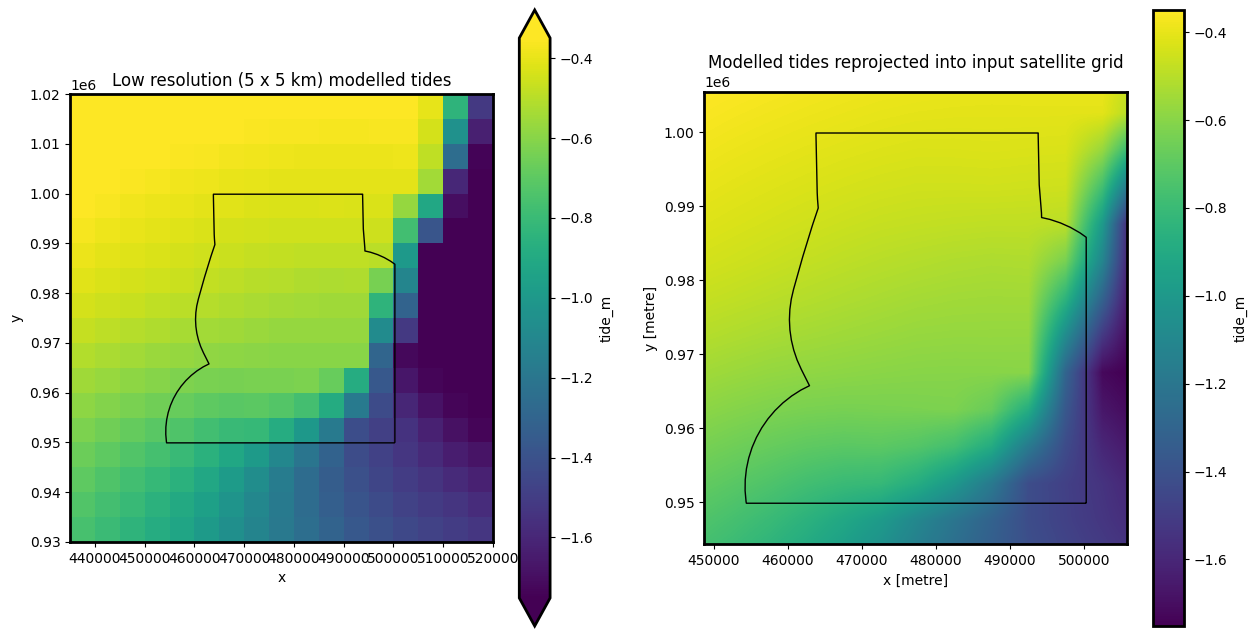

In [18]:
import matplotlib.pyplot as plt

# Plot
timestep = 15
ds_i = ds["tide_m"].isel(time=timestep)
ds_lowres_i = tides_lowres.isel(time=timestep)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
ds_lowres_i.plot.imshow(
    ax=axes[0],
    robust=True,
    cmap="viridis",
    vmin=ds_i.min().item(),
    vmax=ds_i.max().item(),
)
ds_i.plot.imshow(
    ax=axes[1],
    robust=True,
    cmap="viridis",
    vmin=ds_i.min().item(),
    vmax=ds_i.max().item(),
)
for ax in axes:
    gridcell_gdf.to_crs(ds.odc.geobox.crs).plot(
        ax=ax, facecolor="none", edgecolor="black"
    )
axes[0].set_title("Low resolution (5 x 5 km) modelled tides")
axes[1].set_title("Modelled tides reprojected into input satellite grid");

### Calculate per-pixel tide cutoffs
Based on the entire time-series of tide heights, compute the max and min satellite-observed tide height for each pixel, then calculate tide cutoffs used to restrict our data to satellite observations centred over mid-tide (0 m Above Mean Sea Level).

In [19]:
# Determine tide cutoff
tide_cutoff_min, tide_cutoff_max = coastlines.raster.tide_cutoffs(ds, tides_lowres, tide_centre=0.0)

## Generate yearly composites
Export tidally-masked MNDWI median composites for each year, and three-yearly composites used to gapfill poor data coverage areas.

In [20]:
# If output folder doesn't exist, create it
output_dir = f"data/interim/raster/{raster_version}/{study_area}_{raster_version}"
os.makedirs(output_dir, exist_ok=True)

# Iterate through each year and export annual and 3-year gapfill composites
coastlines.raster.export_annual_gapfill(
    ds, output_dir, tide_cutoff_min, tide_cutoff_max, start_year, end_year
)

OSError: [Errno 22] Invalid argument

### Close Dask client

In [ ]:
dask_client.close()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/dea-coastlines/issues/new).

**Last modified:** November 2022

**To cite:**

> Bishop-Taylor, R., Nanson, R., Sagar, S., Lymburner, L. (2021). Mapping Australia's dynamic coastline at mean sea level using three decades of Landsat imagery. Remote Sensing of Environment, 267, 112734. Available: https://doi.org/10.1016/j.rse.2021.112734
>
> Nanson, R., Bishop-Taylor, R., Sagar, S., Lymburner, L., (2022). Geomorphic insights into Australia's coastal change using a national dataset derived from the multi-decadal Landsat archive. Estuarine, Coastal and Shelf Science, 265, p.107712. Available: https://doi.org/10.1016/j.ecss.2021.107712
>
> Bishop-Taylor, R., Sagar, S., Lymburner, L., Alam, I., Sixsmith, J. (2019). Sub-pixel waterline extraction: characterising accuracy and sensitivity to indices and spectra. Remote Sensing, 11 (24):2984. Available: https://doi.org/10.3390/rs11242984